# Testing xray

The monte carlo simulation I am writing would be clearer and less error-prone if we could label the columns by the appliance name.  xray is a library that allows this and I'm going to experiment with it in this notebook.


In [118]:
%matplotlib inline
import numpy as np
import xray
from scipy.stats import binom
import matplotlib.pyplot as plt

I create a table of values using pandas and give the index and columns labels.

In [119]:
import pandas as pd
proportions = pd.Series({'TV':0.5, 'radio': 0.9, 'lighting':0.95})
daily_energy = pd.Series({'TV':10, 'radio': 5, 'lighting':1})
appliance_data = pd.DataFrame({'proportions':proportions, 'daily_energy':daily_energy})
appliance_data.index.name = 'appliance'
appliance_data.columns.name = 'values'
appliance_data

values,daily_energy,proportions
appliance,,
TV,10,0.50
lighting,1,0.95
radio,5,0.90


In [120]:
appliance_data = xray.Dataset.from_dataframe(appliance_data)
#appliance_data

In [121]:
# create an array with the proportions of each appliance for each trial
num_trials = 1000
appliance = ['TV', 'radio']
data = np.ones((num_trials, len(appliance)))
trials = np.arange(num_trials)
sim = xray.DataArray(data, coords=[trials, appliance], dims=['trials', 'appliance'])
# broadcast multiply by the table above
sim = sim * appliance_data['proportions']
sim

<xray.DataArray (trials: 1000, appliance: 2)>
array([[ 0.5,  0.9],
       [ 0.5,  0.9],
       [ 0.5,  0.9],
       ..., 
       [ 0.5,  0.9],
       [ 0.5,  0.9],
       [ 0.5,  0.9]])
Coordinates:
  * trials     (trials) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 ...
  * appliance  (appliance) object 'TV' 'radio'

In [122]:
# perform a binomial sample over each element of array to get number of appliances
# I want a cleaner way to do this
# can I extend a ufunc so that I get a xray object back?
num_households = 100
data = binom.rvs(num_households, sim)
appliance_sim = xray.DataArray(data, coords=[trials, appliance], dims=['trials', 'appliance'])
appliance_sim

<xray.DataArray (trials: 1000, appliance: 2)>
array([[50, 90],
       [47, 92],
       [43, 88],
       ..., 
       [52, 97],
       [51, 88],
       [50, 90]])
Coordinates:
  * trials     (trials) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 ...
  * appliance  (appliance) object 'TV' 'radio'

In [123]:
# multiply by daily energy
energy_sim = appliance_sim * appliance_data['daily_energy']
energy_sim

<xray.DataArray (trials: 1000, appliance: 2)>
array([[500, 450],
       [470, 460],
       [430, 440],
       ..., 
       [520, 485],
       [510, 440],
       [500, 450]])
Coordinates:
  * trials     (trials) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 ...
  * appliance  (appliance) object 'TV' 'radio'

In [124]:
# sum over appliances
daily_simulations = energy_sim.sum('appliance')

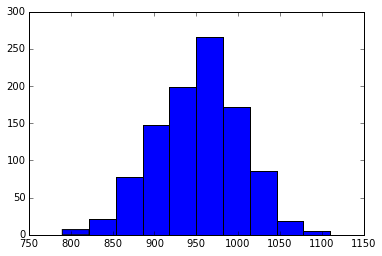

In [125]:
plt.hist(daily_simulations)
plt.show()